In [1]:
!git clone https://github.com/Harshad165/seeps_test

Cloning into 'seeps_test'...
remote: Enumerating objects: 1593, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1593 (delta 2), reused 7 (delta 0), pack-reused 1584
Receiving objects: 100% (1593/1593), 49.85 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Updating files: 100% (1583/1583), done.


In [2]:
import random
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D, UpSampling2D, BatchNormalization, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

In [3]:
# Configuration for image and mask data
img_path = '/content/seeps_test/seep_detection/train_images_256/'
masks_path = '/content/seeps_test/seep_detection/train_masks_256/'

# Initialize storage for image and mask data
images = []
masks = []

# Load images and masks
for filename in os.listdir(img_path):
    img = cv2.imread(img_path + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

    mask = plt.imread(masks_path + filename)
    masks.append(mask)

# Convert to NumPy arrays for efficient processing
images = np.array(images)
masks = np.array(masks)


In [5]:
# Normalize image pixel values
images_process = images / 255

# Prepare masks for compatibility
masks_process = (np.expand_dims(masks, -1) > 0).astype(np.float64)

# Split data into training, testing, and validation sets (80/10/10 split)
X_train, X_test, y_train, y_test = train_test_split(
    images_process, masks_process, test_size=0.2, random_state=1
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=1
)

In [6]:
smooth = 1

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def total_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [7]:
strategy = tf.distribute.get_strategy()
with strategy.scope():

  inputs = Input((256,256,3))

  # Encoding path
  c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(0.1)(p1)

  c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(0.1)(p2)

  c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(0.1)(p3)

  c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
  c4 = BatchNormalization()(c4)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(0.1)(p4)

  # Bottleneck
  c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
  c5 = BatchNormalization()(c5)
  c5 = Dropout(0.1)(c5)

  # Decoding path
  u6 = UpSampling2D((2, 2))(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
  c6 = BatchNormalization()(c6)
  c6 = Dropout(0.1)(c6)

  u7 = UpSampling2D((2, 2))(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
  c7 = BatchNormalization()(c7)
  c7 = Dropout(0.1)(c7)

  u8 = UpSampling2D((2, 2))(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
  c8 = BatchNormalization()(c8)
  c8 = Dropout(0.1)(c8)

  u9 = UpSampling2D((2, 2))(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
  c9 = BatchNormalization()(c9)
  c9 = Dropout(0.1)(c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  # Specify the model name in the Model constructor
  opt  = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
  model.compile(optimizer=opt, loss=focal_tversky, metrics=[iou_coef,dice_coef,'acc'])
  print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [8]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-unet.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val,y_val),
                    callbacks=[earlystopper, checkpointer])


Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.9343 - iou_coef: 0.0271 - dice_coef: 0.0551 - acc: 0.5312
Epoch 1: val_loss improved from inf to 0.97319, saving model to model-unet.h5
79/79 [==============================] - 16s 47ms/step - loss: 0.9343 - iou_coef: 0.0271 - dice_coef: 0.0551 - acc: 0.5312 - val_loss: 0.9732 - val_iou_coef: 0.0119 - val_dice_coef: 0.0274 - val_acc: 0.9832
Epoch 2/100
 1/79 [..............................] - ETA: 2s - loss: 0.9645 - iou_coef: 0.0228 - dice_coef: 0.0289 - acc: 0.5724

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - ETA: 0s - loss: 0.9143 - iou_coef: 0.0375 - dice_coef: 0.0721 - acc: 0.6529
Epoch 2: val_loss improved from 0.97319 to 0.96807, saving model to model-unet.h5
79/79 [==============================] - 3s 35ms/step - loss: 0.9143 - iou_coef: 0.0375 - dice_coef: 0.0721 - acc: 0.6529 - val_loss: 0.9681 - val_iou_coef: 0.0134 - val_dice_coef: 0.0313 - val_acc: 0.9833
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.9024 - iou_coef: 0.0456 - dice_coef: 0.0825 - acc: 0.7086
Epoch 3: val_loss did not improve from 0.96807
79/79 [==============================] - 2s 30ms/step - loss: 0.9024 - iou_coef: 0.0456 - dice_coef: 0.0825 - acc: 0.7086 - val_loss: 0.9779 - val_iou_coef: 0.0104 - val_dice_coef: 0.0253 - val_acc: 0.9822
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.8940 - iou_coef: 0.0521 - dice_coef: 0.0901 - acc: 0.7344
Epoch 4: val_loss improved from 0.96807 to 0.96649, saving model to model-unet.h5
79

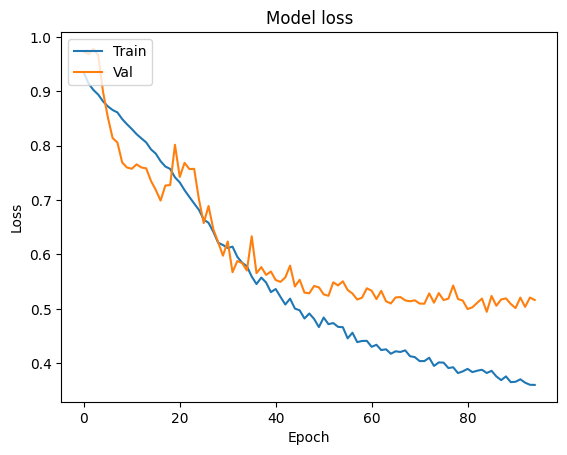

In [9]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [10]:
preds = model.predict(X_test)
model.evaluate(X_test,y_test,batch_size=8)

10/10 [==============================] - 0s 9ms/step - loss: 0.5514 - iou_coef: 0.3194 - dice_coef: 0.5484 - acc: 0.9867


[0.5513970851898193,
 0.3193754553794861,
 0.5484111309051514,
 0.9867033958435059]

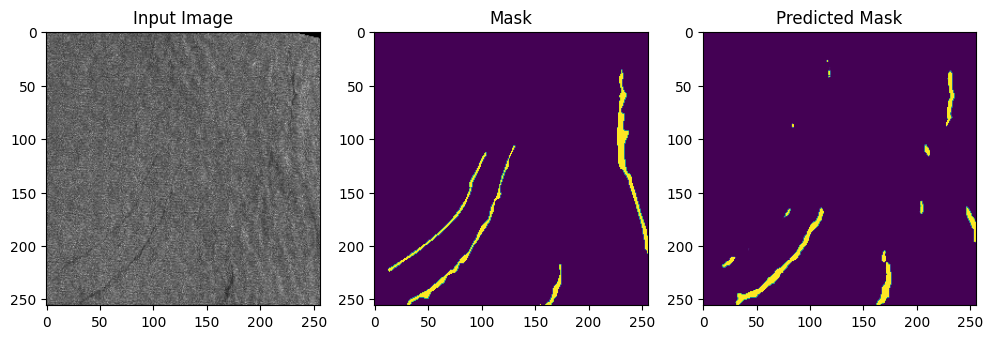

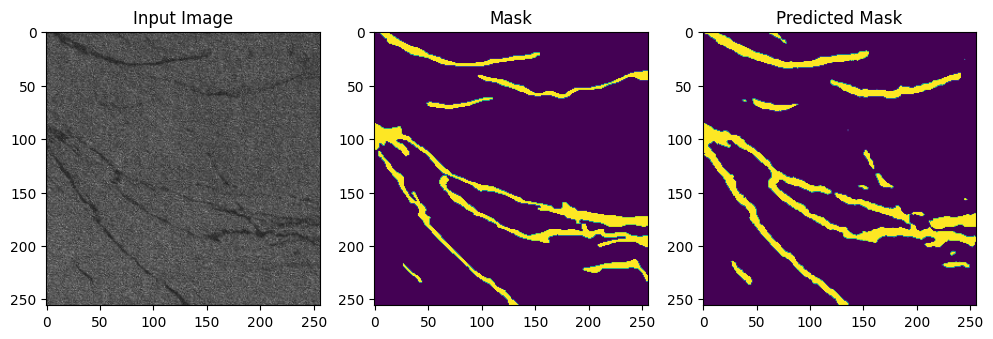

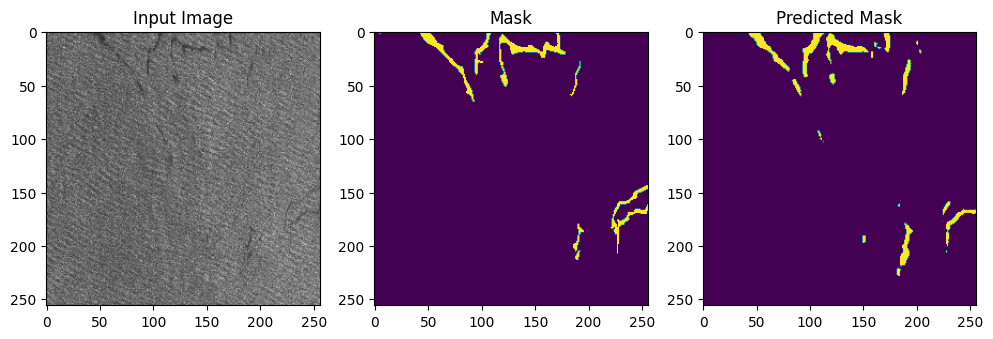

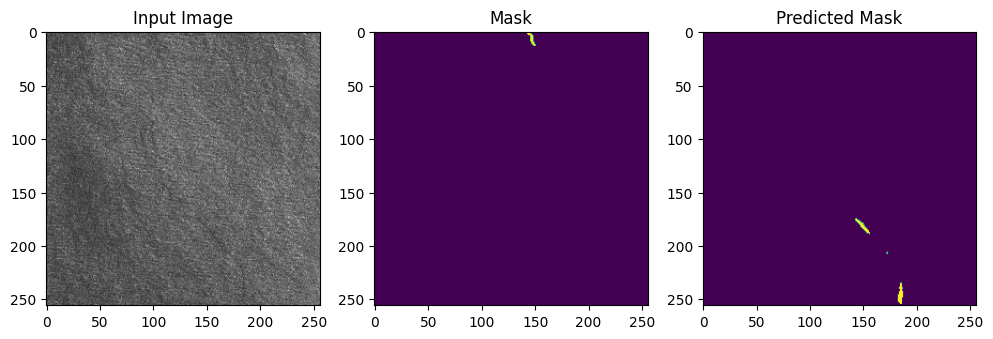

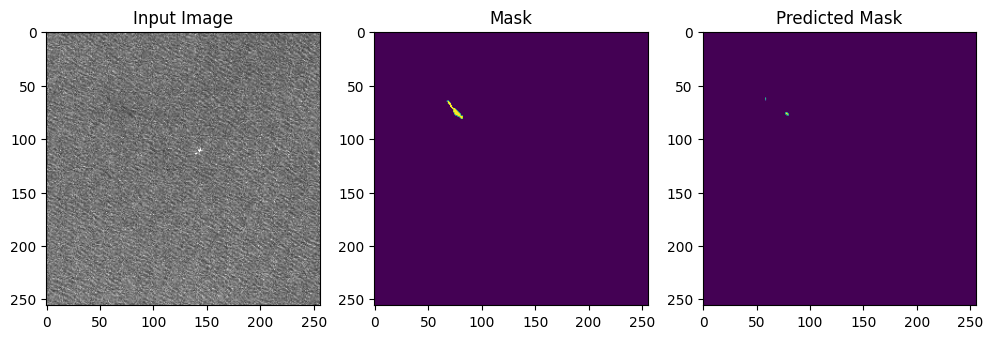

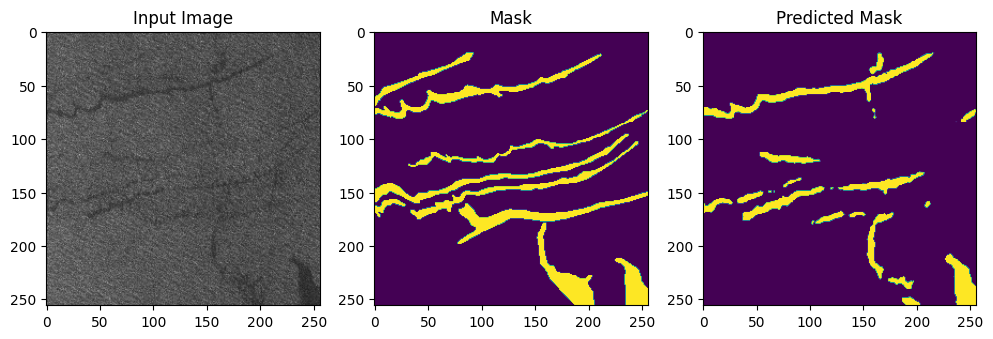

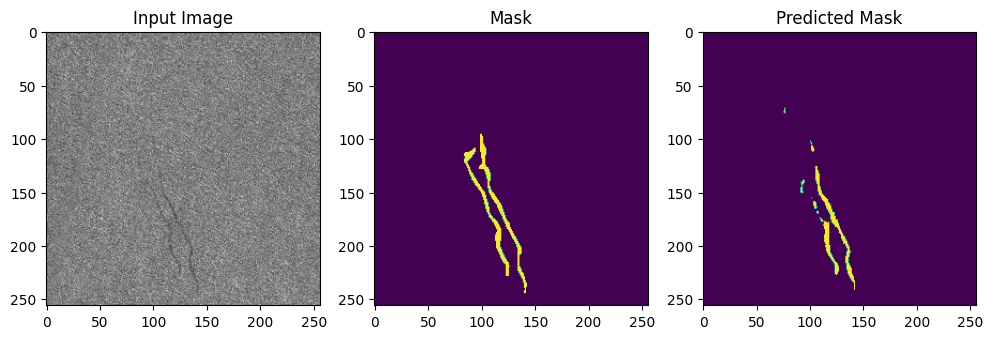

In [11]:
def plot_preds(img, true, pred):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,8))

    ax1.imshow(img)
    ax1.set_title("Input Image")

    ax2.imshow(true)
    ax2.set_title("Mask")

    ax3.imshow(pred)
    ax3.set_title("Predicted Mask")

    plt.show()

for i in range(10):
    plot_preds(X_test[i], y_test[i][:,:,0], preds[i][:,:,0])

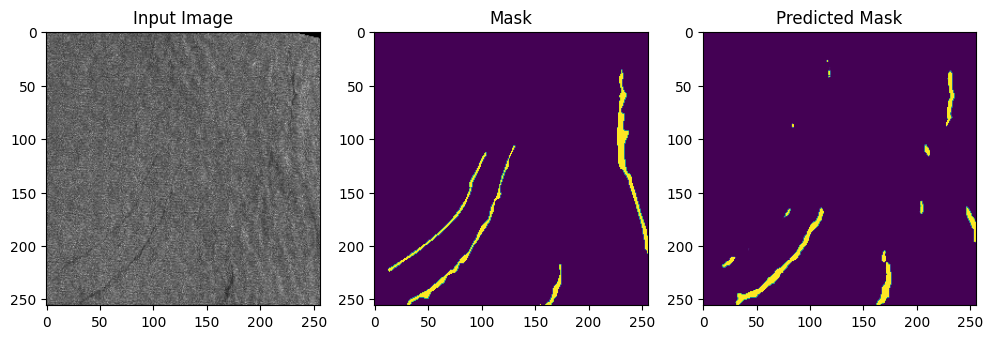

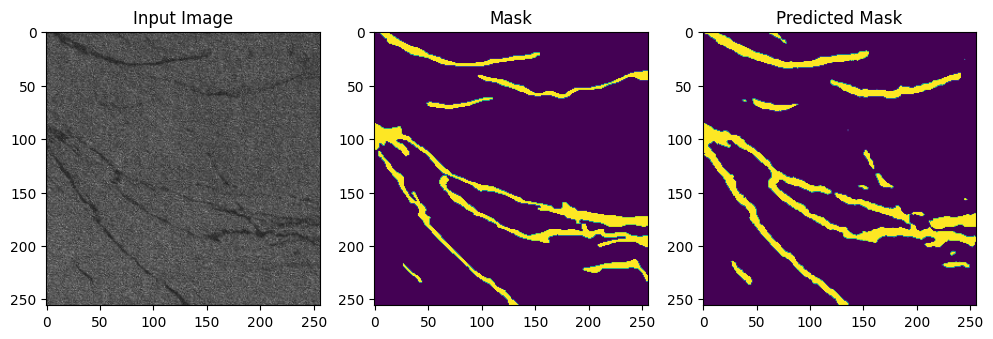

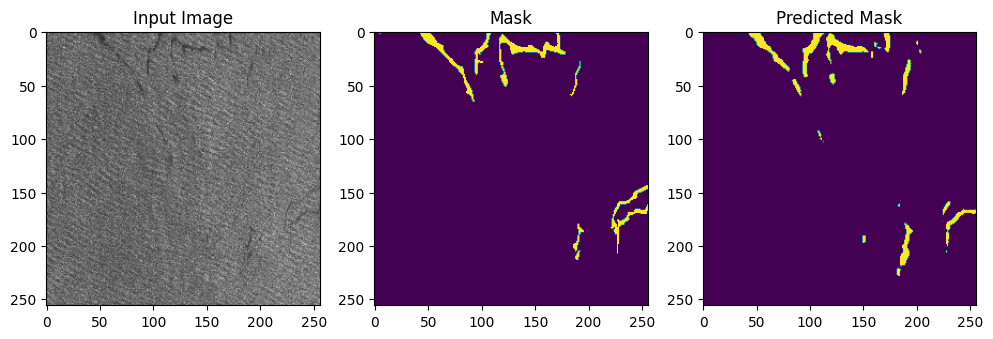

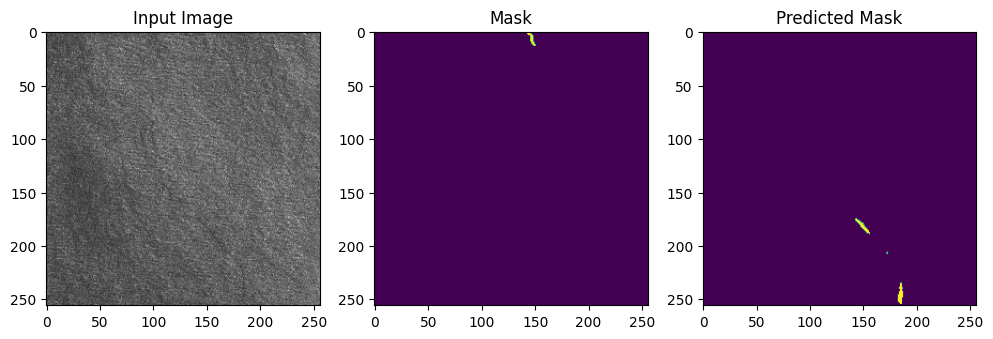

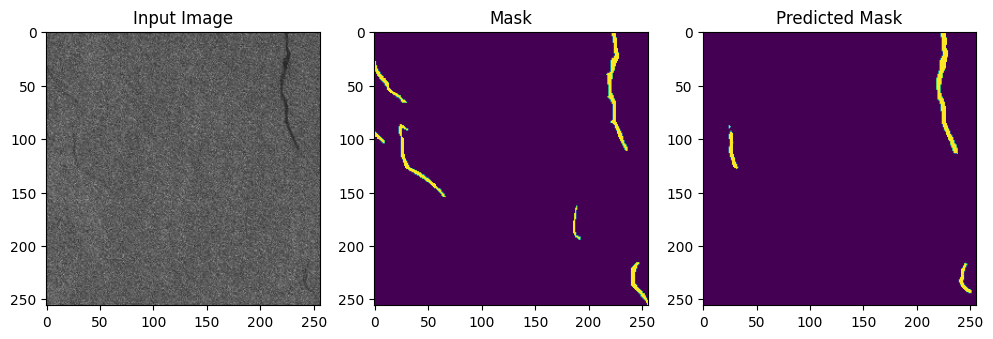

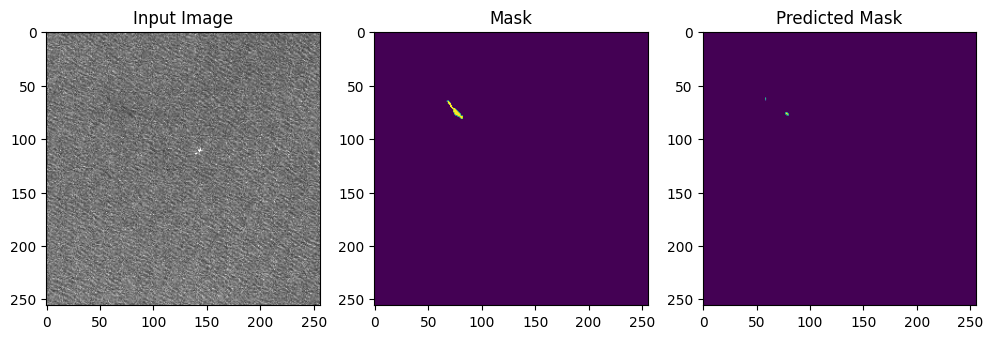

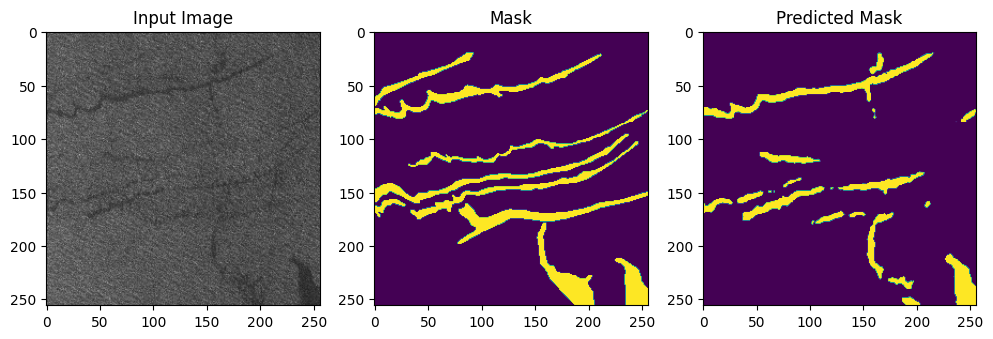

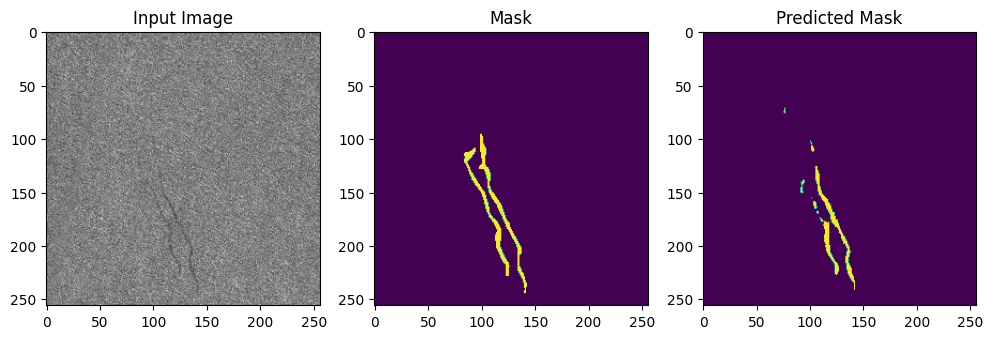

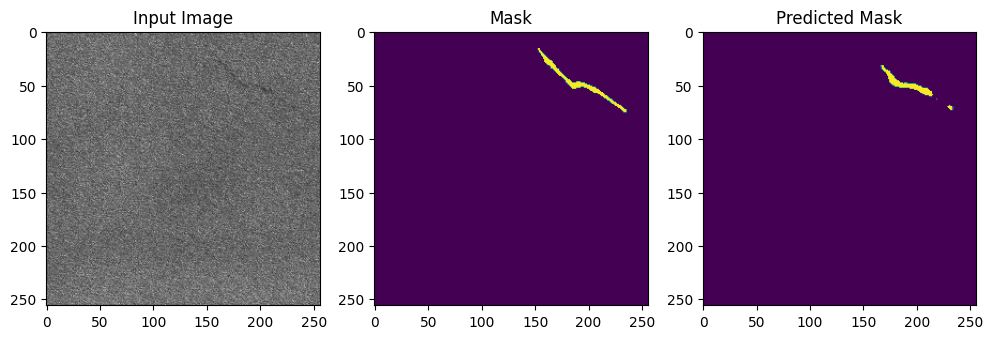

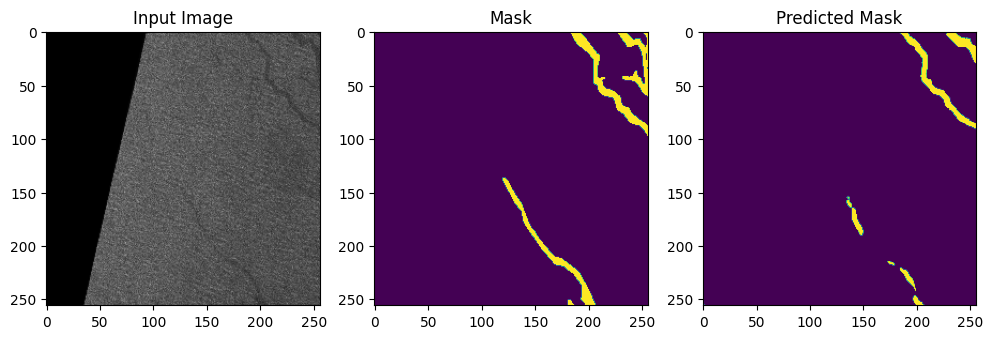

In [12]:
#Run Inference
model = load_model('/content/model-unet.h5', compile = False)

for i in range(10):
    plot_preds(X_test[i], y_test[i][:,:,0], preds[i][:,:,0])